# Arbitrarily high order accurate explicit time integration methods

 1. Chapter 5: ADER and DeC
    1. [Section 1.1: DeC](#DeC)
    1. [Section 1.2: ADER](#ADER)

## Deferred Correction (Defect correction/ Spectral deferred correction)<a id='DeC'></a>
Acronyms: DeC, DEC, DC, SDC

References: [Dutt et al. 2000](https://link.springer.com/article/10.1023/A:1022338906936), [Minion (implicit) 2003](https://projecteuclid.org/journals/communications-in-mathematical-sciences/volume-1/issue-3/Semi-implicit-spectral-deferred-correction-methods-for-ordinary-differential-equations/cms/1250880097.full), [Abgrall 2017 (for PDE)](https://hal.archives-ouvertes.fr/hal-01445543v2)

We study Abgrall's version (for notation)

Theory on slides!

In [ ]:
# If you do not have numpy, matplotlib, scipy or nodepy, run this cell
!pip install numpy
# This is the basic package in python with all the numerical functions

!pip install scipy
# This package has some functions to deal with polynomials

!pip install matplotlib
# This package allows to  plot

!pip install nodepy
# This package has some interesting features for RK methods

In [22]:
# We need a couple of packages in this chapter
import numpy as np  
# This is the basic package in python with all the numerical functions

import matplotlib.pyplot as plt 
# This package allows to  plot

from nodepy import rk
#This package already implemented some functions for Runge Kutta and multistep methods

For the definition of the basis functions in time, we introduce different Lagrange polynomials and point distributions:
1. equispaced
1. Gauss--Legendre--Lobatto (GLB)
1. Gauss--Legendre (not in DeC, because the last point is not $t^{n+1}$)

So, we have the quadrature points $\lbrace t^m \rbrace_{m=0}^M$, the polynomials $\lbrace \varphi_m \rbrace_{m=0}^M$ such that $\varphi_j(t^m)=\delta_{j}^m$, and we are interested in computing

$$
\theta_r^m:=\int_{t^0}^{t^m} \varphi_r(t) dt
$$

To compute the integral we will use exact quadrature rules with Gauss--Lobatto (GLB) points, i.e., given the quadrature nodes and weights $t_q, w_q$ on the interval $[0,1]$ the integral is computed as

$$
\theta_r^m:=\int_{t^0}^{t^m} \varphi_r(t) dt = \sum_q \varphi_r(t^q(t^m-t^0)+t^0) w_q(t^m-t^0) 
$$


In practice, at each timestep we have to loop over corrections $(k)$ and over subtimesteps $m$ and compute

$$
y^{m,(k)} = y^{m,(k-1)} - \left(  y^{m,(k-1)} -  y^{0} - \Delta t\sum_{r=0}^M \theta_r^m F(y^{r,(k-1)}) \right)=y^{0} + \Delta t\sum_{r=0}^M \theta_r^m F(y^{r,(k-1)})
$$

In [25]:
from scipy.interpolate import lagrange
from numpy.polynomial.legendre import leggauss

def equispaced(order):
    '''
    Takes input d and returns the vector of d equispaced points in [-1,1]
    And the integral of the basis functions interpolated in those points
    '''
    nodes= np.linspace(-1,1,order)
    w= np.zeros(order)
    for k in range(order):
        yy= np.zeros(order)
        yy[k]=1.
        zz=lagrange(nodes,yy)
        pp=zz.integ()
        w[k]=pp(1)-pp(-1)

    return nodes, w

def lglnodes(n,eps=10**-15):
    '''
    Python translation of lglnodes.m

    Computes the Legendre-Gauss-Lobatto nodes, weights and the LGL Vandermonde 
    matrix. The LGL nodes are the zeros of (1-x^2)*P'_N(x). Useful for numerical
    integration and spectral methods. 

    Parameters
    ----------
    n : integer, requesting an nth-order Gauss-quadrature rule on [-1, 1]

    Returns
    -------
    (nodes, weights) : tuple, representing the quadrature nodes and weights.
                       Note: (n+1) nodes and weights are returned.
            

    Example
    -------
    >>> from lglnodes import *
    >>> (nodes, weights) = lglnodes(3)
    >>> print(str(nodes) + "   " + str(weights))
    [-1.        -0.4472136  0.4472136  1.       ]   [0.16666667 0.83333333 0.83333333 0.16666667]

    Notes
    -----

    Reference on LGL nodes and weights:  
      C. Canuto, M. Y. Hussaini, A. Quarteroni, T. A. Tang, "Spectral Methods
      in Fluid Dynamics," Section 2.3. Springer-Verlag 1987

    Written by Greg von Winckel - 04/17/2004
        Contact: gregvw@chtm.unm.edu

    Translated and modified into Python by Jacob Schroder - 9/15/2018 
    '''

    w = np.zeros((n+1,))
    x = np.zeros((n+1,))
    xold = np.zeros((n+1,))

    # The Legendre Vandermonde Matrix
    P = np.zeros((n+1,n+1))

    epss = eps

    # Use the Chebyshev-Gauss-Lobatto nodes as the first guess
    for i in range(n+1): 
        x[i] = -np.cos(np.pi*i / n)
  
  
    # Compute P using the recursion relation
    # Compute its first and second derivatives and 
    # update x using the Newton-Raphson method.
    
    xold = 2.0
    
    for i in range(100):
        xold = x
       
        P[:,0] = 1.0 
        P[:,1] = x
       
        for k in range(2,n+1):
            P[:,k] = ( (2*k-1)*x*P[:,k-1] - (k-1)*P[:,k-2] ) / k
       
        x = xold - ( x*P[:,n] - P[:,n-1] )/( (n+1)*P[:,n]) 
        
        if (max(abs(x - xold).flatten()) < epss ):
            break 
    
    w = 2.0 / ( (n*(n+1))*(P[:,n]**2))
    
    return x, w
 
def lagrange_basis(nodes,x,k):
    y=np.zeros(x.size)
    for ix, xi in enumerate(x):
        tmp=[(xi-nodes[j])/(nodes[k]-nodes[j])  for j in range(len(nodes)) if j!=k]
        y[ix]=np.prod(tmp)
    return y

def get_nodes(order,nodes_type):
    if nodes_type=="equispaced":
        nodes,w = equispaced(order)
    elif nodes_type == "gaussLegendre":
        nodes,w = leggauss(order)
    elif nodes_type == "gaussLobatto":
        nodes, w = lglnodes(order-1,10**-15)
    nodes=nodes*0.5+0.5
    w = w*0.5
    return nodes, w
        
def compute_theta_DeC(order, nodes_type):
    nodes, w = get_nodes(order,nodes_type)
    int_nodes, int_w = get_nodes(order,"gaussLobatto")
    # generate theta coefficients 
    theta = np.zeros((order,order))
    beta = np.zeros(order)
    for m in range(order):
        beta[m] = nodes[m]
        nodes_m = int_nodes*(nodes[m])
        w_m = int_w*(nodes[m])
        for r in range(order):
            theta[r,m] = sum(lagrange_basis(nodes,nodes_m,r)*w_m)
    return theta, beta


def compute_RK_from_DeC(M_sub,K_corr,nodes_type):
    order=M_sub+1;
    [theta,beta]=compute_theta_DeC(order,nodes_type)
    bar_beta=beta[1:]  # M_sub
    bar_theta=theta[:,1:].transpose() # M_sub x (M_sub +1)
    theta0= bar_theta[:,0]  # M_sub x 1
    bar_theta= bar_theta[:,1:] #M_sub x M_sub
    A=np.zeros((M_sub*(K_corr-1)+1,M_sub*(K_corr-1)+1))  # (M_sub x K_corr +1)^2
    b=np.zeros(M_sub*(K_corr-1)+1)
    c=np.zeros(M_sub*(K_corr-1)+1)

    c[1:M_sub+1]=bar_beta
    A[1:M_sub+1,0]=bar_beta
    for k in range(1,K_corr-1):
        r0=1+M_sub*k
        r1=1+M_sub*(k+1)
        c0=1+M_sub*(k-1)
        c1=1+M_sub*(k)
        c[r0:r1]=bar_beta
        A[r0:r1,0]=theta0
        A[r0:r1,c0:c1]=bar_theta
    b[0]=theta0[-1]
    b[-M_sub:]=bar_theta[M_sub-1,:]
    return A,b,c


In [3]:
## Deferred correction algorithm

def dec(func, tspan, y_0, M_sub, K_corr, distribution):
    N_time=len(tspan)
    dim=len(y_0)
    U=np.zeros((dim, N_time))
    u_p=np.zeros((dim, M_sub+1))
    u_a=np.zeros((dim, M_sub+1))
    rhs= np.zeros((dim,M_sub+1))
    Theta, beta = compute_theta_DeC(M_sub+1,distribution)
    U[:,0]=y_0
    for it in range(1, N_time):
        delta_t=(tspan[it]-tspan[it-1])
        for m in range(M_sub+1):
            u_a[:,m]=U[:,it-1]
            u_p[:,m]=U[:,it-1]
        for k in range(1,K_corr+1):
            u_p=np.copy(u_a)
            for r in range(M_sub+1):
                rhs[:,r]=func(u_p[:,r])
            for m in range(1,M_sub+1):
                u_a[:,m]= U[:,it-1]+delta_t*sum([Theta[r,m]*rhs[:,r] for r in range(M_sub+1)])
        U[:,it]=u_a[:,M_sub]
    return tspan, U

In [16]:
import numpy as np

## Linear scalar Dahlquist's equation
def linear_scalar_flux(u,t=0,k_coef=10):
    ff=np.zeros(np.shape(u))
    ff[0]= -k_coef*u[0]
    return ff

def linear_scalar_exact_solution(u0,t,k_coef=10):
    return np.array([np.exp(-k_coef*u0[0]*t)])


def linear_scalar_jacobian(u,t=0,k_coef=10):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-k_coef
    return Jf

#nonlinear problem y'=-ky|y| +1  
def nonlinear_scalar_flux(u,t=0,k_coef=10):
    ff=np.zeros(np.shape(u))
    ff[0]=-k_coef*abs(u[0])*u[0] +1
    return ff


def nonlinear_scalar_exact_solution(u0,t,k_coef = 10):
        sqrtk = np.sqrt(k_coef)
        ustar = 1 / sqrtk
        if u0[0] >= ustar:
            uex=np.array([1./np.tanh(sqrtk * t + np.arctanh(1/sqrtk /u0[0])) / sqrtk])
        elif u0[0] < 0 and t < - np.atan(sqrtk * u0[0]) / sqrtk:
            uex=np.array([np.tan(sqrtk * t + np.arctan(sqrtk * u0[0])) / sqrtk])
        else:
            uex=np.array([np.tanh(sqrtk * t + np.arctanh(sqrtk * u0[0])) / sqrtk])
        return uex

def nonlinear_scalar_jacobian(u,t=0,k_coef=10):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-k_coef*abs(u[0])
    return Jf


# SYSTEMS


# linear systems
def linear_system2_flux(u,t=0):
    d=np.zeros(len(u))
    d[0]= -5*u[0] + u[1]
    d[1]= 5*u[0] -u[1]
    return d


def linear_system2_exact_solution(u0,t):
    A=np.array([[-5,1],[5,-1]])
    u_e=u0+(1-np.exp(-6*t))/6*np.dot(A,u0)
    return u_e

def linear_system2_jacobian(u,t=0):
    Jf=np.array([[-5,1],[5,-1]])
    return Jf

linear_system2_matrix = np.array([[-5,1],[5,-1]])

def linear_system2_production_destruction(u,t=0):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[0,1]=u[1]
    d[1,0]=u[1]
    p[1,0]=5*u[0]
    d[0,1]=5*u[0]
    return p,d

#lin system 3 x3

def linear_system3_flux(u,t=0):
    d=np.zeros(len(u))
    d[0]= -u[0] + 3*u[1]
    d[1]= -3*u[1] + 5*u[2]
    d[2]= -5*u[2] 
    return d


def linear_system3_exact_solution(u0,t=0):
    u_e = np.zeros(len(u0))
    u_e[0] = 15.0/8.0*u0[2]*(np.exp(-5*t) - 2*np.exp(-3*t)+np.exp(-t))
    u_e[1] = 5.0/2.0*u0[2]*(-np.exp(-5*t) + np.exp(-3*t))
    u_e[2] = u0[2]*np.exp(-5*t)
    return u_e
def linear_system3_jacobian(u,t=0):
    Jf=np.zeros((len(u),len(u)))
    Jf[0,0]=-1.
    Jf[0,1]=3
    Jf[1,1] = -3
    Jf[1,2] = 5
    Jf[2,2] = -5 
    return Jf


## Nonlinear 3x3 system production destruction
def nonlinear_system3_flux(u,t=0):
    ff=np.zeros(len(u))
    ff[0]= -u[0]*u[1]/(u[0]+1)
    ff[1]= u[0]*u[1]/(u[0]+1) -0.3*u[1]
    ff[2]= 0.3*u[1]
    return ff

def nonlinear_system3_production_destruction(u,t=0):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[1,0]=u[0]*u[1]/(u[0]+1)
    d[0,1]=p[1,0]
    p[2,1]=0.3*u[1]
    d[1,2]=p[2,1]
    return p,d


# SIR Model
def SIR_flux(u,t=0,beta=3,gamma=1):
    ff=np.zeros(len(u))
    N=np.sum(u)
    ff[0]=-beta*u[0]*u[1]/N
    ff[1]=+beta*u[0]*u[1]/N - gamma*u[1]
    ff[2]= gamma*u[1]
    return ff

def SIR_jacobian(u,t=0,beta=3,gamma=1):
    Jf=np.zeros((len(u),len(u)))
    N=np.sum(u)
    Jf[0,0]=-beta*u[1]/N
    Jf[0,1]=-beta*u[0]/N
    Jf[1,0]= beta*u[1]/N
    Jf[1,1]= beta*u[0]/N - gamma
    Jf[2,1] = gamma 
    return Jf

def SIR_production_destruction(u,t=0,beta=3,gamma=1):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    N=np.sum(u)
    p[1,0]=beta*u[0]*u[1]/N
    d[0,1]=p[1,0]
    p[2,1]=gamma*u[1]
    d[1,2]=p[2,1]
    return p,d

# Nonlinear_oscillator
def nonLinearOscillator_flux(u,t=0,alpha=0.):
    ff=np.zeros(np.shape(u))
    n=np.sqrt(np.dot(u,u))
    ff[0]=-u[1]/n-alpha*u[0]/n
    ff[1]=u[0]/n - alpha*u[1]/n
    return ff

def nonLinearOscillator_exact_solution(u0,t):
    u_ex=np.zeros(np.shape(u0))
    n=np.sqrt(np.dot(u0,u0))
    u_ex[0]=np.cos(t/n)*u0[0]-np.sin(t/n)*u0[1]
    u_ex[1]=np.sin(t/n)*u0[0]+np.cos(t/n)*u0[1]
    return u_ex


# Non linear oscillator damped
def nonLinearOscillatorDamped_flux(u,t,alpha=0.01):
    ff=np.zeros(np.shape(u))
    n=np.sqrt(np.dot(u,u))
    ff[0]=-u[1]/n-alpha*u[0]/n
    ff[1]=u[0]/n - alpha*u[1]/n
    return ff

def nonLinearOscillatorDamped_exact_solution(u0,t,alpha=0.01):
    u_ex=np.zeros(np.shape(u0))
    n0=np.sqrt(np.dot(u0,u0))
    n=n0*np.exp(-alpha*t)
    u_ex[0]=n/n0*(np.cos(t/n)*u0[0]-np.sin(t/n)*u0[1])
    u_ex[1]=n/n0*(np.sin(t/n)*u0[0]+np.cos(t/n)*u0[1])
    return u_ex


# pendulum
def pendulum_flux(u,t=0):
    ff=np.zeros(np.shape(u))
    ff[0]=u[1]
    ff[1]=-np.sin(u[0])
    return ff

def pendulum_jacobian(u,t=0):
    Jf=np.zeros((2,2))
    Jf[0,1]=1.
    Jf[1,0]=np.cos(u[0])
    return Jf

def pendulum_entropy(u,t=0):
    return np.array(0.5*u[1]**2.-np.cos(u[0]), dtype=np.float)

def pendulum_entropy_variables(u,t=0):
    v=np.zeros(np.shape(u))
    v[0]=np.sin(u[0])
    v[1]=u[1]
    return v

# Robertson
def Robertson_flux(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    ff=np.zeros(np.shape(u))
    ff[0] = alpha*u[1]*u[2]-beta*u[0]
    ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
    ff[2] = gamma*u[1]**2
    return ff

def Robertson_jacobian(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    Jf=np.zeros((3,3))
    Jf[0,0]= -beta 
    Jf[0,1]= alpha*u[2]
    Jf[0,2]= alpha*u[1]
    Jf[1,0]= beta
    Jf[1,1]= -alpha*u[2]-2*gamma*u[1]
    Jf[1,2]= -alpha*u[1]
    Jf[2,1] = 2*gamma*u[1] 
    return Jf

def Robertson_production_destruction(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    p=np.zeros((len(u),len(u)))
    d=np.zeros((len(u),len(u)))
    p[0,1]=alpha*u[1]*u[2]
    d[1,0]=p[0,1]
    p[1,0]=beta*u[0]
    d[0,1]=p[1,0]
    p[2,1]=gamma*u[1]**2
    d[1,2]=p[2,1]
    return p,d

def Robertson_rhs(u,t=0):
    return np.zeros(3)

  
# Lotka:
def lotka_flux(u,t=0,alpha=1,beta=0.2,delta=0.5,gamma=0.2):
    ff=np.zeros(np.shape(u))
    ff[0]=alpha*u[0]-beta*u[0]*u[1]
    ff[1]=delta*beta*u[0]*u[1]-gamma*u[1]
    return ff

def lotka_jacobian(u,t=0,alpha=1,beta=0.2,delta=0.5,gamma=0.2):
    Jf=np.zeros((2,2))
    Jf[0,0] = alpha -beta*u[1]
    Jf[0,1] = -beta*u[0]
    Jf[1,0] = delta*beta*u[1]
    Jf[1,1] = delta*beta*u[0] -gamma
    return Jf


#3 bodies problem in 2D: U=(x_1,x_2,v_1,v_2,y_1,y_2,w_1,w_2,z_1,z_2,s_1,s_2)
# where x is the 2D position of body1 and v is speed body1 sun
# y, w are position and velocity body2 earth
# z, s are position and velocity body3 mars

def threeBodies_flux(u,t=0):
    m1=1.98892*10**30
    m2=5.9722*10**24
    m3=6.4185*10**23
    G=6.67*10**(-11)
    f=np.zeros(np.shape(u))
    x=u[0:2]
    v=u[2:4]
    y=u[4:6]
    w=u[6:8]
    z=u[8:10]
    s=u[10:12]
    dxy3=np.linalg.norm(x-y)**3
    dxz3=np.linalg.norm(x-z)**3
    dyz3=np.linalg.norm(y-z)**3
    f[0:2]=v
    f[2:4]=-m2*G/dxy3*(x-y)-m3*G/dxz3*(x-z)
    f[4:6]=w
    f[6:8]=-m1*G/dxy3*(y-x)-m3*G/dyz3*(y-z)
    f[8:10]=s
    f[10:12]=-m1*G/dxz3*(z-x)-m2*G/dyz3*(z-y)
    return f


class ODEproblem:
    def __init__(self,name):
        self.name=name
        if self.name=="linear_scalar":
            self.u0 = np.array([1.])
            self.T_fin= 2.
            self.k_coef=10
            self.matrix=np.array([-self.k_coef])
        elif self.name=="nonlinear_scalar":
            self.k_coef=10
            self.u0 = np.array([1.1/np.sqrt(self.k_coef)])
            self.T_fin= 1.
        elif self.name=="linear_system2":
            self.u0 = np.array([0.9,0.1])
            self.T_fin= 1.
            self.matrix = np.array([[-5,1],[5,-1]])
        elif self.name=="linear_system3":
            self.u0 = np.array([0,0.,10.])
            self.T_fin= 10.
        elif self.name=="nonlinear_system3":
            self.u0 = np.array([9.98,0.01,0.01])
            self.T_fin= 30.
        elif self.name=="SIR":
            self.u0 = np.array([1000.,1,10**-20])
            self.T_fin= 10.
        elif self.name=="nonLinearOscillator":
            self.u0 = np.array([1.,0.])
            self.T_fin= 50
        elif self.name=="nonLinearOscillatorDamped":
            self.u0 = np.array([1.,0.])
            self.T_fin= 50
        elif self.name=="Robertson":
            self.u0 = np.array([1.,10**-20,10**-20])
            self.T_fin= 10.**10.
        elif self.name=="lotka":
            self.u0 = np.array([1.,2.])
            self.T_fin= 100.
        elif self.name=="threeBodies":
            self.u0 = np.array([0,0,0,0,149*10**9,0,0,30*10**3,-226*10**9,0,0,-24.0*10**3])
            self.T_fin= 10.**8.
        else:
            raise ValueError("Problem not defined")

    def flux(self,u,t=0):
        if self.name=="linear_scalar":
            return linear_scalar_flux(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_flux(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_flux(u,t)
        elif self.name=="linear_system3":
            return linear_system3_flux(u,t)
        elif self.name=="nonlinear_system3":
            return nonlinear_system3_flux(u,t)
        elif self.name=="SIR":
            return SIR_flux(u,t)
        elif self.name=="nonLinearOscillator":
            return nonLinearOscillator_flux(u,t)
        elif self.name=="nonLinearOscillatorDamped":
            return nonLinearOscillatorDamped_flux(u,t)
        elif self.name=="Robertson":
            return Robertson_flux(u,t)
        elif self.name=="lotka":
            return lotka_flux(u,t)
        elif self.name=="threeBodies":
            return threeBodies_flux(u,t)
        else:
            raise ValueError("Flux not defined for this problem")
        
    def jacobian(self,u,t=0):
        if self.name=="linear_scalar":
            return linear_scalar_jacobian(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_jacobian(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_jacobian(u,t)
        elif self.name=="linear_system3":
            return linear_system3_jacobian(u,t)
        elif self.name=="SIR":
            return SIR_jacobian(u,t)
        elif self.name=="Robertson":
            return Robertson_jacobian(u,t)
        elif self.name=="lotka":
            return lotka_jacobian(u,t)
        else:
            raise ValueError("Jacobian not defined for this problem")

    def exact(self,u,t):
        if self.name=="linear_scalar":
            return linear_scalar_exact_solution(u,t,self.k_coef)
        elif self.name=="nonlinear_scalar":
            return nonlinear_scalar_exact_solution(u,t,self.k_coef)
        elif self.name=="linear_system2":
            return linear_system2_exact_solution(u,t)
        elif self.name=="linear_system3":
            return linear_system3_exact_solution(u,t)
        elif self.name=="nonLinearOscillator":
            return nonLinearOscillator_exact_solution(u,t)
        elif self.name=="nonLinearOscillatorDamped":
            return nonLinearOscillatorDamped_exact_solution(u,t)
        else:
            raise ValueError("Exact solution not defined for this problem")
            
    def exact_solution_times(self,u0,tt):
        exact_solution=np.zeros((len(u0),len(tt)))
        for it, t in enumerate(tt):
            exact_solution[:,it]=self.exact(u0,t)
        return exact_solution

    def prod_dest(self,u,t=0):
        if self.name=="linear_system2":
            return linear_system2_production_destruction(u,t)
        if self.name=="nonlinear_system3":
            return nonlinear_system3_production_destruction(u,t)
        elif self.name=="Robertson":
            return Robertson_production_destruction(u,t)
        elif self.name=="SIR":
            return SIR_production_destruction(u,t)
        else:
            raise ValueError("Prod Dest not defined for this problem")

        

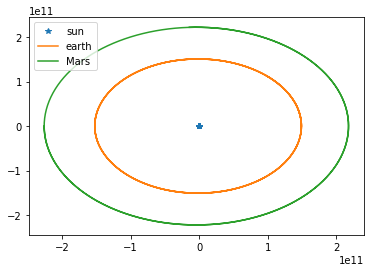

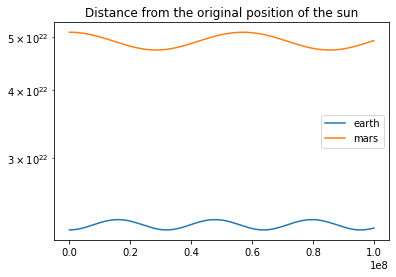

In [6]:
pr=ODEproblem("threeBodies")
tt=np.linspace(0,pr.T_fin,1000)
tt,U=dec(pr.flux,tt,pr.u0,4,5,"gaussLobatto")
plt.figure()
plt.plot(U[0,:],U[1,:],'*',label="sun")
plt.plot(U[4,:],U[5,:],label="earth")
plt.plot(U[8,:],U[9,:],label="Mars")
plt.legend()
plt.show()

plt.figure()
plt.title("Distance from the original position of the sun")
plt.semilogy(tt,U[4,:]**2+U[5,:]**2,label="earth")
plt.semilogy(tt,U[8,:]**2+U[9,:]**2, label="mars")
plt.legend()
plt.show()

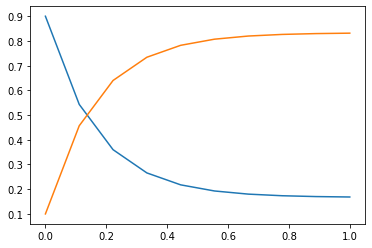

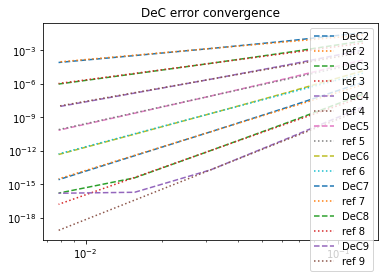

In [19]:
#Test convergence
pr=ODEproblem("linear_system2")

tt=np.linspace(0,pr.T_fin,10)
tt,uu=dec(pr.flux, tt, pr.u0, 7, 8, "equispaced")
plt.plot(tt,uu[0,:])
plt.plot(tt,uu[1,:])
plt.show()

def compute_integral_error(c,c_exact):  # c is dim x times
    times=np.shape(c)[1]
    error=0.
    for t in range(times):
        error = error + np.linalg.norm(c[:,t]-c_exact[:,t],2)**2.
    error = np.sqrt(error/times) 
    return error

NN=5
dts=[pr.T_fin/2.0**k for k in range(3,3+NN)]
errorsDeC=np.zeros(len(dts))

for order in range(2,10):
    for k in range(NN):
        dt0=dts[k]
        tt=np.arange(0,pr.T_fin,dt0)
        t2,U2=dec(pr.flux, tt, pr.u0, order-1, order, "gaussLobatto")
        u_exact=pr.exact_solution_times(pr.u0,tt)
        errorsDeC[k]=compute_integral_error(U2,u_exact)

    plt.loglog(dts,errorsDeC,"--",label="DeC%d"%(order))
    plt.loglog(dts,[dt**order*errorsDeC[2]/dts[2]**order for dt in dts],":",label="ref %d"%(order))


plt.title("DeC error convergence")
plt.legend()
#plt.savefig("convergence_DeC.pdf")
plt.show()


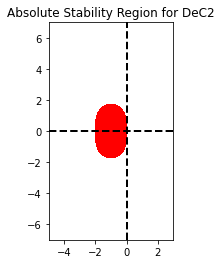

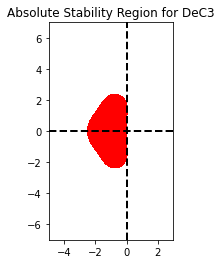

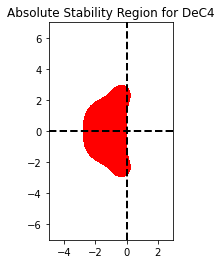

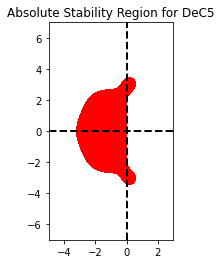

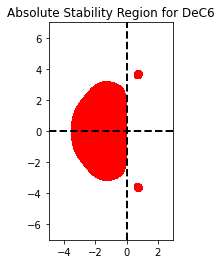

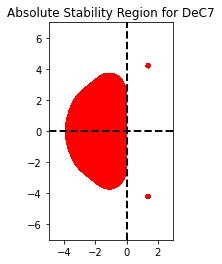

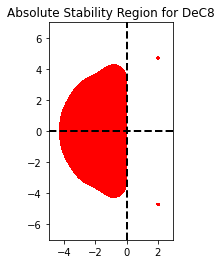

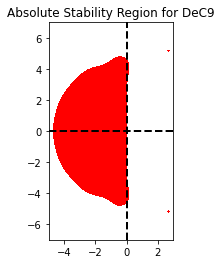

In [30]:
for order in range(2,10):
    A,b,c=compute_RK_from_DeC(order-1,order,"equispaced")
    rkDeC = rk.ExplicitRungeKuttaMethod(A,b)
    rkDeC.name="DeC"+str(order)
    rkDeC.plot_stability_region(bounds=[-5,3,-7,7])

In [34]:
for order in range(2,14):
    A,b,c=compute_RK_from_DeC(order-1,order,"equispaced")
    rkDeC = rk.ExplicitRungeKuttaMethod(A,b)
    rkDeC.name="DeC"+str(order)
    print(rkDeC.name+" has order "+str(rkDeC.order()))

DeC2 has order 2
DeC3 has order 3
DeC4 has order 4
DeC5 has order 5
DeC6 has order 6
DeC7 has order 7
DeC8 has order 8
DeC9 has order 9
DeC10 has order 10
DeC11 has order 11
DeC12 has order 12
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
DeC13 has order 13


Text(0.5, 1.0, 'Predator')

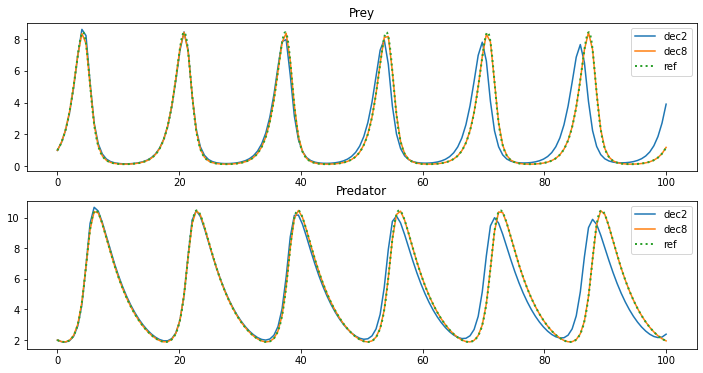

In [42]:
pr=ODEproblem("lotka")
tt=np.linspace(0,pr.T_fin,150)
t2,U2=dec(pr.flux, tt, pr.u0, 1, 2, "gaussLobatto")
t8,U8=dec(pr.flux, tt, pr.u0, 7, 8, "gaussLobatto")

tt=np.linspace(0,pr.T_fin,2000)
tref,Uref=dec(pr.flux, tt, pr.u0, 4,5, "gaussLobatto")

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(t2,U2[0,:],label="dec2")
plt.plot(t8,U8[0,:],label="dec8")
plt.plot(tref,Uref[0,:], ":",linewidth=2,label="ref")
plt.legend()
plt.title("Prey")

plt.subplot(212)
plt.plot(t2,U2[1,:],label="dec2")
plt.plot(t8,U8[1,:],label="dec8")
plt.plot(tref,Uref[1,:],":", linewidth=2,label="ref")
plt.legend()
plt.title("Predator")

### Pro exercise: implement the implicit DeC presented in the slides
* You need to pass also a function of the Jacobian of the flux in input
* The Jacobian can be evaluated only once per timestep $\partial_y F(y^n)$ and used to build the matrix that must be inverted at each correction
* For every subtimestep the matrix to be inverted changes a bit ($\beta^m \Delta t$ factor in front of the Jacobian)
* One can invert these $M$ matrices only once per time step
* Solve the system at each subtimestep and iteration

$$
y^{m,(k)}-\beta^m \Delta t \partial_y F(y^0)y^{m,(k)} = y^{m,(k-1)}-\beta^m \Delta t \partial_y F(y^0)y^{m,(k-1)} - \left(  y^{m,(k-1)} -  y^{0} - \Delta t\sum_{r=0}^M \theta_r^m F(y^{r,(k-1)}) \right)
$$

defining $M^{m}=I+\beta^m \Delta t \partial_y F(y^0)$, we can simplify it as 

$$
y^{m,(k)}=y^{m,(k-1)} - (M^m)^{-1}\left(  y^{m,(k-1)} -  y^{0} - \Delta t\sum_{r=0}^M \theta_r^m F(y^{r,(k-1)}) \right)
$$

In [48]:
def decImplicit(func,jac_stiff, tspan, y_0, M_sub, K_corr, distribution):
    N_time=len(tspan)
    dim=len(y_0)
    U=np.zeros((dim, N_time))
    u_p=np.zeros((dim, M_sub+1))
    u_a=np.zeros((dim, M_sub+1))
    u_help= np.zeros(dim)
    rhs= np.zeros((dim,M_sub+1))
    Theta, beta = compute_theta_DeC(M_sub+1,distribution)
    invJac=np.zeros((M_sub+1,dim,dim))
    U[:,0]=y_0
    for it in range(1, N_time):
        delta_t=(tspan[it]-tspan[it-1])
        for m in range(M_sub+1):
            u_a[:,m]=U[:,it-1]
            u_p[:,m]=U[:,it-1]
        SS=jac_stiff(u_p[:,0])
        for m in range(1,M_sub+1):
            invJac[m,:,:]=np.linalg.inv(np.eye(dim) - delta_t*beta[m]*SS)
        for k in range(1,K_corr+1):
            u_p=np.copy(u_a)
            for r in range(M_sub+1):
                rhs[:,r]=func(u_p[:,r])
            for m in range(1,M_sub+1):
                u_a[:,m]= u_p[:,m]+delta_t*np.matmul(invJac[m,:,:],\
                (-(u_p[:,m]-u_p[:,0])/delta_t\
                 +sum([Theta[r,m]*rhs[:,r] for r in range(M_sub+1)])))
        U[:,it]=u_a[:,M_sub]
    return tspan, U

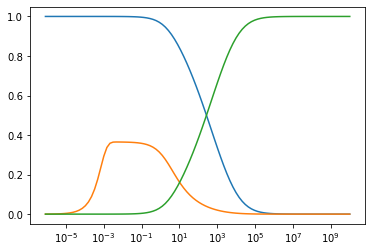

In [53]:
# Test on Robertson problem
pr=ODEproblem("Robertson")

Nt=100
tt = np.array([np.exp(k) for k in np.linspace(-14,np.log(pr.T_fin),Nt)])
tt,yy=decImplicit(pr.flux,pr.jacobian, tt, pr.u0, 5,6,"gaussLobatto")

plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])

<ipython-input-16-d077bf4081f1>:183: RuntimeWarning: overflow encountered in double_scalars
  ff[0] = alpha*u[1]*u[2]-beta*u[0]
<ipython-input-16-d077bf4081f1>:184: RuntimeWarning: overflow encountered in double_scalars
  ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
<ipython-input-16-d077bf4081f1>:184: RuntimeWarning: invalid value encountered in double_scalars
  ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
<ipython-input-16-d077bf4081f1>:185: RuntimeWarning: overflow encountered in double_scalars
  ff[2] = gamma*u[1]**2
<ipython-input-3-f7740b482a20>:22: RuntimeWarning: invalid value encountered in add
  u_a[:,m]= U[:,it-1]+delta_t*sum([Theta[r,m]*rhs[:,r] for r in range(M_sub+1)])


(-0.05, 1.05)

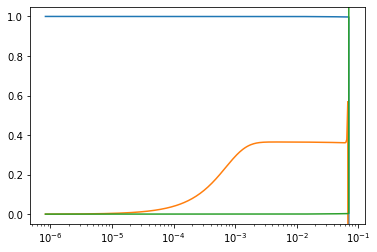

In [56]:
Nt=1000
tt = np.array([np.exp(k) for k in np.linspace(-14,np.log(pr.T_fin),Nt)])
tt,yy=dec(pr.flux, tt, pr.u0, 5,6,"gaussLobatto")

plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])
plt.ylim([-0.05,1.05])

## ADER <a id='ADER'></a>

In [65]:
from scipy.interpolate import lagrange

def lagrange_poly(nodes,k):
    interpVal=np.zeros(np.size(nodes))
    interpVal[k] = 1.
    pp=lagrange(nodes,interpVal)
    return pp

def lagrange_basis(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    return pp(x)

def lagrange_deriv(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    dd=pp.deriv()
    return dd(x)

def get_nodes(order,nodes_type):
    if nodes_type=="equispaced":
        nodes,w = equispaced(order)
    elif nodes_type == "gaussLegendre":
        nodes,w = leggauss(order)
    elif nodes_type == "gaussLobatto":
        nodes, w = lglnodes(order-1,10**-15)
    nodes=nodes*0.5+0.5
    w = w*0.5
    return nodes, w
        
def getADER_matrix(order, nodes_type):
    nodes_poly, w_poly = get_nodes(order,nodes_type)
    if nodes_type=="equispaced":
        quad_order=order
        nodes_quad, w = get_nodes(quad_order,"gaussLegendre")
    else:
        quad_order=order
        nodes_quad, w = get_nodes(quad_order,nodes_type)
                    
    # generate mass matrix
    M = np.zeros((order,order))
    for i in range(order):
        for j in range(order):
            M[i,j] = lagrange_basis(nodes_poly,1.0,i) *lagrange_basis(nodes_poly,1.0,j)\
                  -sum([lagrange_deriv(nodes_poly,nodes_quad[q],i)\
                  *lagrange_basis(nodes_poly,nodes_quad[q],j)\
                  *w[q] for q in range(quad_order)])
    # generate mass matrix
    RHSmat = np.zeros((order,order))
    for i in range(order):
        for j in range(order):
            RHSmat[i,j] = sum([lagrange_basis(nodes_poly,nodes_quad[q],i)*\
                               lagrange_basis(nodes_poly,nodes_quad[q],j)*\
                               w[q] for q in range(quad_order)])
    return nodes_poly, w_poly, M, RHSmat

def ader(func, tspan, y_0, M_sub, K_corr, distribution):
    N_time=len(tspan)
    dim=len(y_0)
    U=np.zeros((dim, N_time))
    u_p=np.zeros((dim, M_sub+1))
    u_a=np.zeros((dim, M_sub+1))
    u_tn=np.zeros((dim, M_sub+1))
    rhs= np.zeros((dim,M_sub+1))
    
    x_poly, w_poly, ADER, RHS_mat = getADER_matrix(M_sub+1, distribution)
    invader = np.linalg.inv(ADER)
    evolMatrix=np.matmul(invader,RHS_mat)
    reconstructionCoefficients=np.array([lagrange_basis(x_poly,1.0,i) for i in range(M_sub+1)])
    
    U[:,0]=y_0
    
    for it in range(1, N_time):
        delta_t=(tspan[it]-tspan[it-1])
        for m in range(M_sub+1):
            u_a[:,m]=U[:,it-1]
            u_p[:,m]=U[:,it-1]
            u_tn[:,m]=U[:,it-1]
        for k in range(1,K_corr+1):
            u_p=np.copy(u_a)
            for r in range(M_sub+1):
                rhs[:,r]=func(u_p[:,r])
            for d in range(dim):
                u_a[d,:] = u_tn[d,:] + delta_t*np.matmul(evolMatrix,rhs[d,:])
        U[:,it] = np.matmul(u_a,reconstructionCoefficients)
    return tspan, U

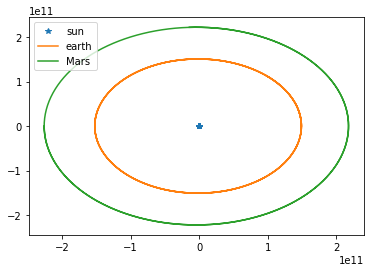

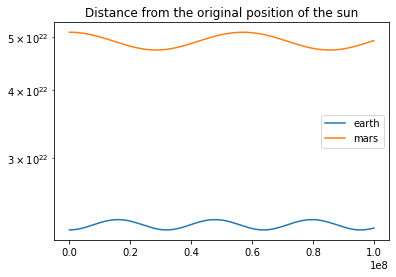

In [67]:
pr=ODEproblem("threeBodies")
tt=np.linspace(0,pr.T_fin,1000)
tt,U=ader(pr.flux,tt,pr.u0,4,5,"gaussLegendre")
plt.figure()
plt.plot(U[0,:],U[1,:],'*',label="sun")
plt.plot(U[4,:],U[5,:],label="earth")
plt.plot(U[8,:],U[9,:],label="Mars")
plt.legend()
plt.show()

plt.figure()
plt.title("Distance from the original position of the sun")
plt.semilogy(tt,U[4,:]**2+U[5,:]**2,label="earth")
plt.semilogy(tt,U[8,:]**2+U[9,:]**2, label="mars")
plt.legend()
plt.show()

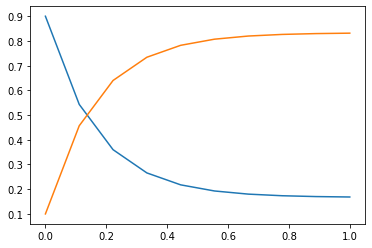

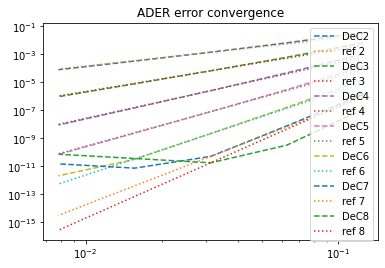

In [69]:
#Test convergence
pr=ODEproblem("linear_system2")

tt=np.linspace(0,pr.T_fin,10)
tt,uu=ader(pr.flux, tt, pr.u0, 7, 8, "equispaced")
plt.plot(tt,uu[0,:])
plt.plot(tt,uu[1,:])
plt.show()

def compute_integral_error(c,c_exact):  # c is dim x times
    times=np.shape(c)[1]
    error=0.
    for t in range(times):
        error = error + np.linalg.norm(c[:,t]-c_exact[:,t],2)**2.
    error = np.sqrt(error/times) 
    return error

NN=5
dts=[pr.T_fin/2.0**k for k in range(3,3+NN)]
errorsDeC=np.zeros(len(dts))

for order in range(2,8):
    for k in range(NN):
        dt0=dts[k]
        tt=np.arange(0,pr.T_fin,dt0)
        t2,U2=ader(pr.flux, tt, pr.u0, order-1, order, "gaussLobatto")
        u_exact=pr.exact_solution_times(pr.u0,tt)
        errorsDeC[k]=compute_integral_error(U2,u_exact)

    plt.loglog(dts,errorsDeC,"--",label="ADER%d"%(order))
    plt.loglog(dts,[dt**order*errorsDeC[2]/dts[2]**order for dt in dts],":",label="ref %d"%(order))


plt.title("ADER error convergence")
plt.legend()
#plt.savefig("convergence_ADER.pdf")
plt.show()


Text(0.5, 1.0, 'Predator')

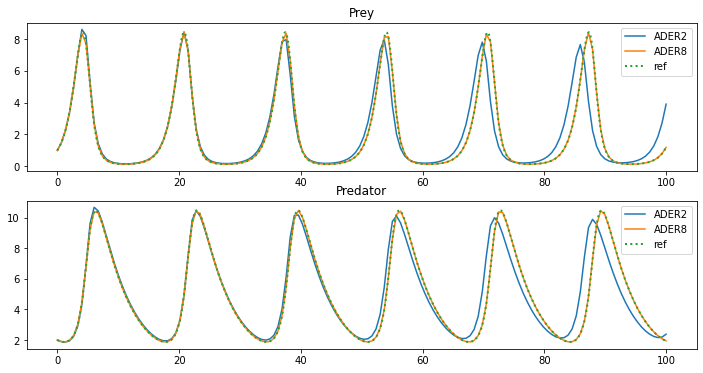

In [70]:
pr=ODEproblem("lotka")
tt=np.linspace(0,pr.T_fin,150)
t2,U2=ader(pr.flux, tt, pr.u0, 1, 2, "gaussLobatto")
t8,U8=ader(pr.flux, tt, pr.u0, 7, 8, "gaussLobatto")

tt=np.linspace(0,pr.T_fin,2000)
tref,Uref=dec(pr.flux, tt, pr.u0, 4,5, "gaussLobatto")

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(t2,U2[0,:],label="ADER2")
plt.plot(t8,U8[0,:],label="ADER8")
plt.plot(tref,Uref[0,:], ":",linewidth=2,label="ref")
plt.legend()
plt.title("Prey")

plt.subplot(212)
plt.plot(t2,U2[1,:],label="ADER2")
plt.plot(t8,U8[1,:],label="ADER8")
plt.plot(tref,Uref[1,:],":", linewidth=2,label="ref")
plt.legend()
plt.title("Predator")

### Pro exercise: implicit ADER
Using the fact that ADER can be written into DeC, try to make ADER implicit by changing only the definition of $\mathcal{L}^1$

* Write the formulation and the update formula
* Implement it adding (as for the DeC an extra input of the jacobian of the flux)

### Pro exercise: ADER as RK
How can you write the ADER scheme into a RK setting?
At the end we are computing some coefficients in a more elaborated way to use them explicitly, so one should be able to write it down.

### Few notes on the stability
Computing the stability region of the ADER method results, for a fixed order of accuracy, for any point distribution to the same stability region. This coincide with the DeC method stability region for the same order of accuracy.

This can be shown numerically, I put here some plots, but no analytical proof is available yet.

**Stability for ADER and DeC methods with $p$ subtimesteps**

| ADER        | ADER vs DeC |
| ----------- | ----------- |
| ![ADERStability](images/chapter5/stabilityADER.png)  | ![ADERStability](images/chapter5/stabilityADERvsDeC.png)     |
